# Load the eval data

In [1]:
import sys
import yaml
import json
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
root = Path.cwd().parent
sys.path.append(str(root))
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern"}) 

from train import Trainer

with open(root / "configs" / "generators.yaml", "r") as f:
    config = yaml.safe_load(f)

def readable(name):
    if isinstance(name, list):
        return [readable_str(x) for x in name]
    elif isinstance(name, str):
        return readable_str(name)

def readable_str(name):
    for input_type in config:
        for inp_name in config[input_type]:
            if inp_name in name:
                if 'name' in config[input_type][inp_name]:
                    return config[input_type][inp_name]['name']
                else: 
                    return inp_name.capitalize()

In [2]:
mat_name = 'isotropic-swift'
train_inp_name = 'pd_ms_42_200'

model_folder = Path(root,'metrics',mat_name,train_inp_name)
model_dirs = list(model_folder.iterdir())

100%|██████████| 184/184 [00:13<00:00, 13.59it/s]


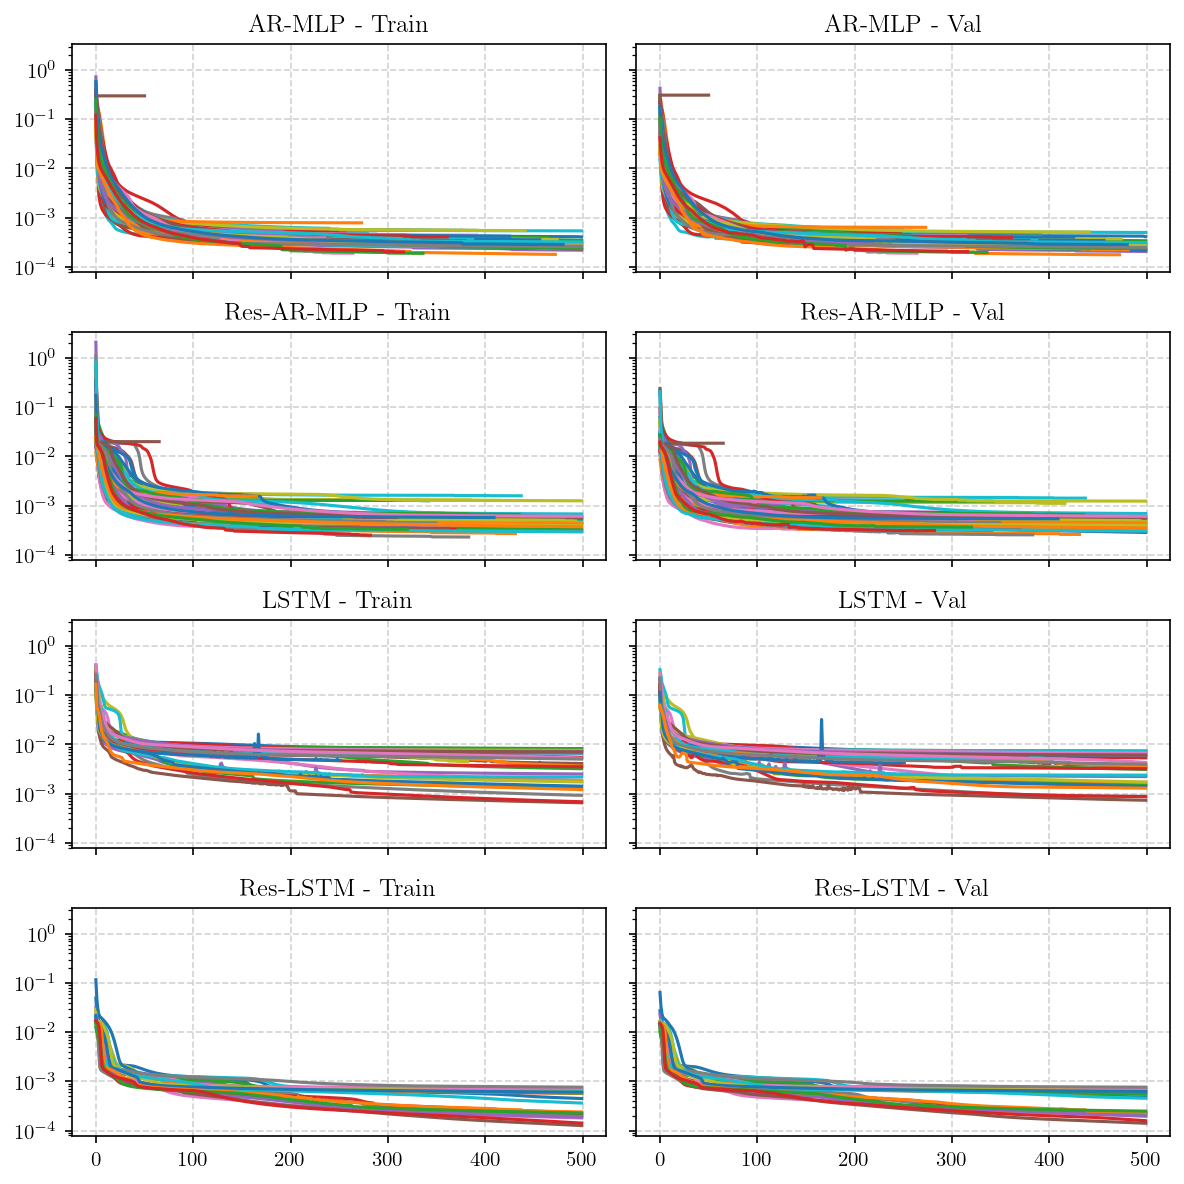

In [3]:
fig, ax = plt.subplots(4,2,figsize=(8,8),dpi=150,sharex=True,sharey=True)

for model_dir in tqdm(model_dirs):

    trainer = Trainer(
        mat_name,train_inp_name,
        config_path='../configs/train.yaml',
        data_dir='../data',
    )
    trainer.load(model_dir/'model.pth')
    
    if not trainer.model.incr and trainer.model.network_name == 'MLP' : 
        ax[0,0].plot(trainer.train_losses)
        ax[0,1].plot(trainer.val_losses)
    if trainer.model.incr and trainer.model.network_name == 'MLP' : 
        ax[1,0].plot(trainer.train_losses)
        ax[1,1].plot(trainer.val_losses)
    if not trainer.model.incr and trainer.model.network_name == 'LSTM': 
        ax[2,0].plot(trainer.train_losses)
        ax[2,1].plot(trainer.val_losses)
    if trainer.model.incr and trainer.model.network_name == 'LSTM': 
        ax[3,0].plot(trainer.train_losses)
        ax[3,1].plot(trainer.val_losses)


ax[0,0].set_title('AR-MLP - Train')
ax[0,1].set_title('AR-MLP - Val')
ax[1,0].set_title('Res-AR-MLP - Train')
ax[1,1].set_title('Res-AR-MLP - Val')
ax[2,0].set_title('LSTM - Train')
ax[2,1].set_title('LSTM - Val')
ax[3,0].set_title('Res-LSTM - Train')
ax[3,1].set_title('Res-LSTM - Val')
    
for a in ax.flatten(): 
    a.set_yscale('log')
    a.grid(ls='--',color='lightgray')

plt.tight_layout()
plt.savefig(root  / 'figures' / 'grid-search-convergence.png',dpi=250)
plt.show()

100%|██████████| 184/184 [00:04<00:00, 42.16it/s]


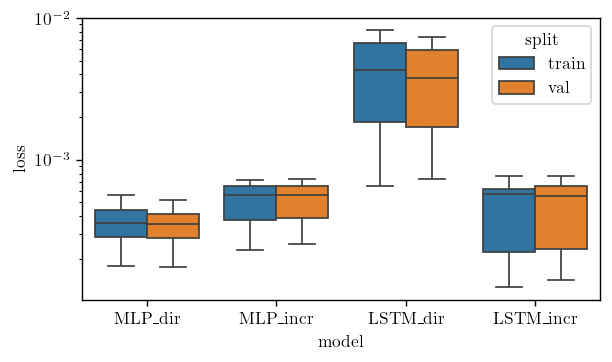

In [ ]:
rows = []
for model_dir in tqdm(model_dirs):
    trainer = Trainer(
        mat_name,train_inp_name,
        config_path='../configs/train.yaml',
        data_dir='../data',
    )
    trainer.load(model_dir/'model.pth')

    key = f"{trainer.model.network_name}_{trainer.model.mode}"   # e.g. MLP_dir, LSTM_incr
    
    rows.append((key, "train", trainer.train_losses[-1]))
    rows.append((key, "val", trainer.val_losses[-1]))

    eval_metrics_path = Path(model_folder,trainer.model.name,'eval_metrics.json',)

    with open(eval_metrics_path,'rb') as f:
        error_metrics = json.load(f)

    line_loc.append(error_metrics[eval_inp_name]['local'][measure])

df = pd.DataFrame(rows, columns=["model", "split", "loss"])

df["model"] = pd.Categorical(df["model"],["MLP_dir","MLP_incr","LSTM_dir","LSTM_incr"])

plt.figure(figsize=(5,3),dpi=125)

sns.boxplot(
    data=df,
    x="model",
    y="loss",
    hue="split",
    showfliers=False,
    
)
plt.yscale("log")
plt.tight_layout()
plt.show()

In [5]:
measure = 'RMSE'

eval_inp_names = [
    'amplitude','cyclic','impulse','piecewise','resolution',
    'bl_ms_42_200','gp_42_200','rw_42_200'
]

cols = [
    'name','network','output_type',
    'k','p','q','seed',
    'num_params','num_states'
]

results_glob, results_loc = [], []

for model_dir in tqdm(model_dirs):
    trainer = Trainer(
        mat_name,train_inp_name,
        config_path='../configs/train.yaml',
        data_dir='../data',
    )
    trainer.load(model_dir/'model.pth')
    
    line_glob = [
        trainer.model.name,
        trainer.model.network_name, 
        trainer.model.mode, 
        trainer.model.k,
        trainer.model.p,
        trainer.model.q,
        trainer.model.seed,
        trainer.model.num_params,
        (trainer.model.k if trainer.model.network_name == 'MLP' else 2*trainer.model.p*trainer.model.q)
    ]
    line_loc = line_glob.copy()
    
    eval_metrics_path = Path(model_folder,trainer.model.name,'eval_metrics.json',)
    test_eval_path = Path(model_folder,trainer.model.name,'test_eval.json',)
    
    with open(eval_metrics_path,'rb') as f:
        error_metrics = json.load(f)

    with open(test_eval_path,'rb') as f:
        test_eval = json.load(f)
    
    line_glob.append(test_eval['global'][measure])
    line_loc.append(test_eval['local'][measure])
    
    for eval_inp_name in eval_inp_names:

        line_glob.append(error_metrics[eval_inp_name]['global'][measure])
        line_loc.append(error_metrics[eval_inp_name]['local'][measure])

    results_glob.append(line_glob)
    results_loc.append(line_loc)


eval_inp_names = ['Test'] + readable(eval_inp_names)
df_glob = pd.DataFrame(results_glob, columns=cols+eval_inp_names)
df_loc = pd.DataFrame(results_loc, columns=cols+eval_inp_names)

100%|██████████| 184/184 [00:13<00:00, 13.44it/s]


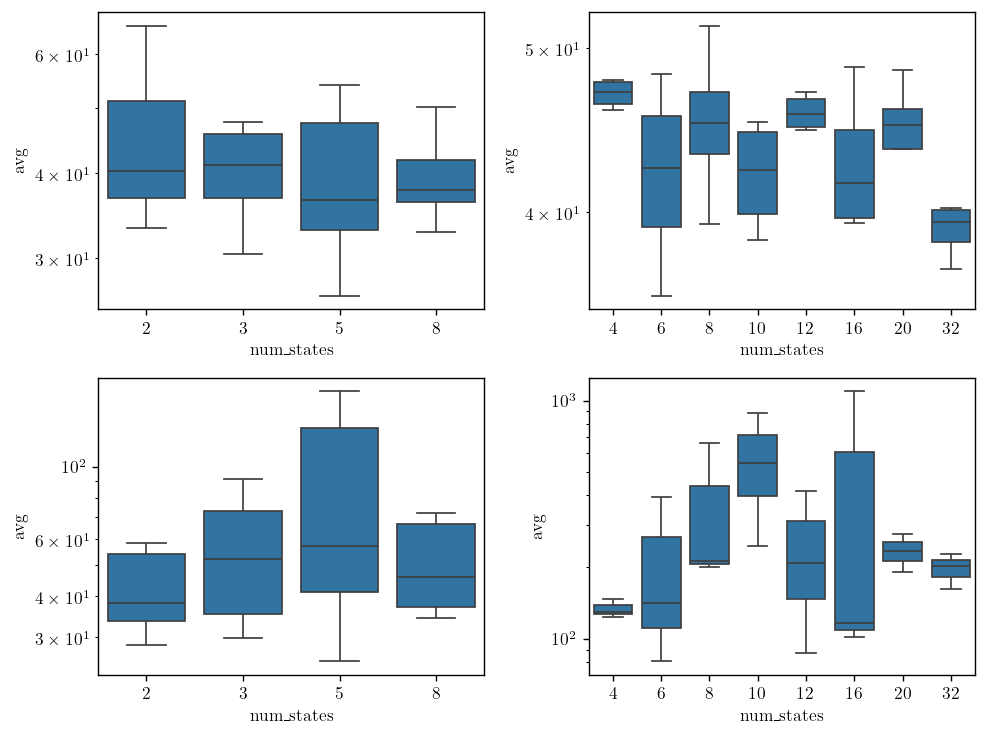

In [7]:
fig, ax = plt.subplots(2,2,figsize=(8,6),dpi=125)

for i,mode in enumerate(['dir','incr']):
    for j,network_name in enumerate(['MLP','LSTM']):

        df = df_glob[
            (df_glob['network']==network_name) & 
            (df_glob['output_type']==mode)
        ].copy()
        df['avg'] = df[eval_inp_names].mean(axis=1)/1e6

        sns.boxplot(x='num_states', y='avg', data=df, showfliers=False,ax=ax[i,j])
        ax[i,j].set_yscale('log')

plt.tight_layout()
plt.show()

# Eval the modelling approach

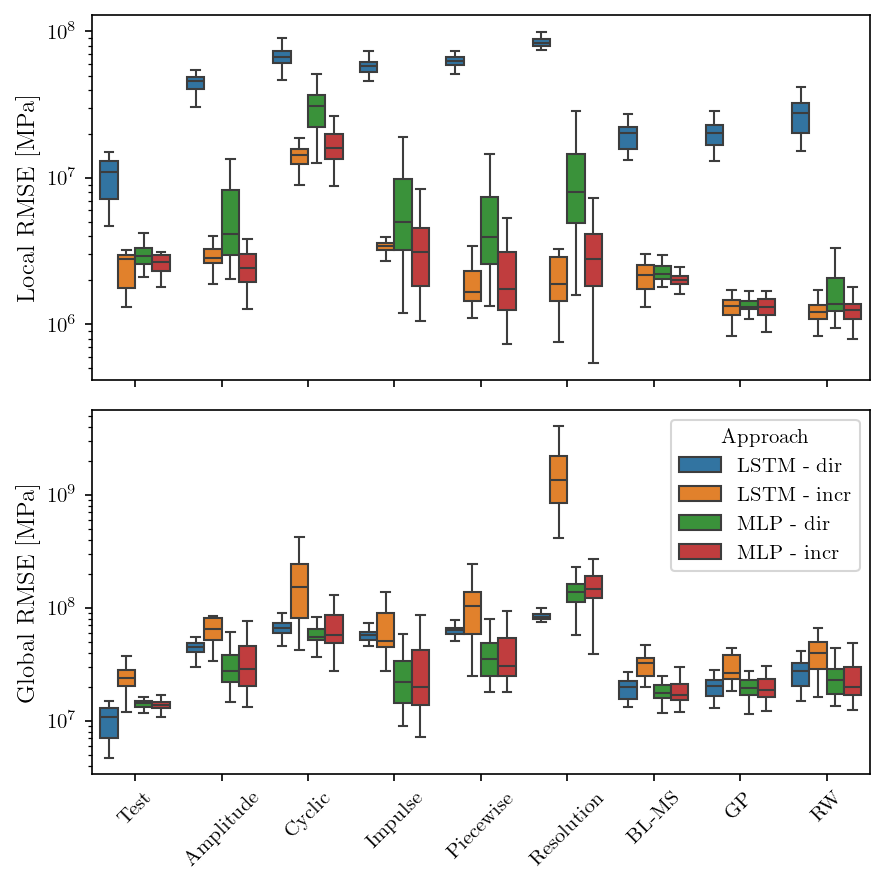

In [29]:
fig, ax = plt.subplots(2, figsize=(6,6),dpi=150,sharex=True)

df_tmp = df_loc[['network','output_type'] + eval_inp_names]
df_tmp = df_tmp.melt(id_vars=['network','output_type'], var_name='dataset', value_name='score')
df_tmp['approach'] = df_tmp['network'] + ' - ' + df_tmp['output_type']
sns.boxplot(x='dataset', y='score', hue='approach', data=df_tmp, showfliers=False, ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_xlabel('')
ax[0].set_ylabel('Local RMSE [MPa]',fontsize=12)
ax[0].legend_.remove()

df_tmp = df_glob[['network','output_type'] + eval_inp_names]
df_tmp = df_tmp.melt(id_vars=['network','output_type'], var_name='dataset', value_name='score')
df_tmp['approach'] = df_tmp['network'] + ' - ' + df_tmp['output_type']
sns.boxplot(x='dataset', y='score', hue='approach', data=df_tmp, showfliers=False, ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_xlabel('')
ax[1].set_ylabel('Global RMSE [MPa]',fontsize=12)
ax[1].legend(title='Approach')
ax[1].tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.savefig(root  / 'figures' / 'grid-search-rmse.png',dpi=250)
plt.show()

Az LSTM incr és LSTM dir között miért ilyen jelentős az eltérés a lokális hibában? Elméletileg az adott méretű LSTM minden idősorra ugyanolyan jól kéne illeszkedjen, nem? Nem értem.

Plot the top 3 surrogate models on piecewise set (based on global and local error)

In [30]:
df_glob.sort_values('Test')[:15][['name','num_params'] + eval_inp_names]

,name,num_params,Test,Amplitude,Cyclic,Impulse,Piecewise,Resolution,BL-MS,GP,RW
15,LSTM-dir-2-8-2-17,1001,4.695647e+06,4.399789e+07,6.701909e+07,5.724604e+07,5.659287e+07,8.131740e+07,1.309741e+07,1.512100e+07,2.302293e+07
23,LSTM-dir-3-8-2-38,1033,4.904710e+06,4.656507e+07,5.483268e+07,5.186262e+07,6.754077e+07,8.644415e+07,1.312379e+07,1.678741e+07,1.872816e+07
7,LSTM-dir-0-8-2-83,937,5.268338e+06,4.076102e+07,6.870177e+07,5.230227e+07,5.336022e+07,7.911867e+07,1.409055e+07,1.569299e+07,2.028848e+07
30,LSTM-dir-5-8-1-42,521,5.857881e+06,4.111471e+07,5.363600e+07,4.924579e+07,7.330032e+07,8.845637e+07,1.520850e+07,1.281510e+07,1.503170e+07
31,LSTM-dir-5-8-2-56,1097,6.009037e+06,3.215233e+07,4.573913e+07,4.653555e+07,7.045038e+07,8.455599e+07,1.525795e+07,1.449114e+07,1.759374e+07
22,LSTM-dir-3-8-1-64,457,6.095871e+06,4.792186e+07,8.904744e+07,6.125439e+07,6.780543e+07,7.618596e+07,1.357604e+07,1.326170e+07,1.556811e+07
6,LSTM-dir-0-8-1-75,361,6.600131e+06,5.487515e+07,7.337315e+07,6.378005e+07,6.615776e+07,9.977104e+07,2.120499e+07,2.147901e+07,3.122375e+07
28,LSTM-dir-5-5-1-83,266,6.896898e+06,4.891482e+07,6.581279e+07,5.718937e+07,7.792058e+07,9.828798e+07,1.517920e+07,1.610909e+07,2.078517e+07
21,LSTM-dir-3-5-2-56,466,7.131503e+06,5.219737e+07,6.160866e+07,6.081606e+07,6.852301e+07,9.387059e+07,1.680696e+07,1.979706e+07,2.307597e+07
4,LSTM-dir-0-5-1-29,166,7.981377e+06,3.197624e+07,8.107367e+07,4.593538e+07,6.626162e+07,7.558606e+07,1.695741e+07,1.712097e+07,2.026246e+07


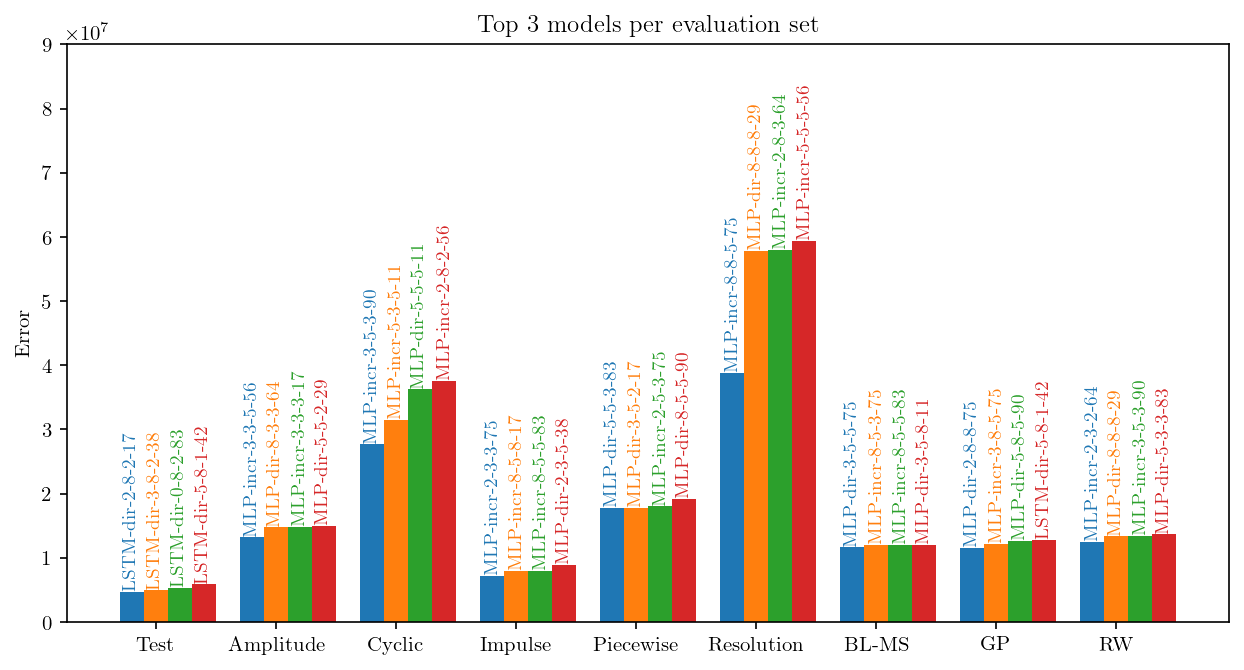

In [41]:
plot_data = []

for eval_inp_name in eval_inp_names:
    top4 = df_glob.sort_values(eval_inp_name).head(4)
    for _, row in top4.iterrows():
        plot_data.append({
            "test": eval_inp_name,
            "model": row["name"],
            "error": row[eval_inp_name]
        })

plot_df = pd.DataFrame(plot_data)

# Now plot
eval_inp_names = plot_df["test"].unique()
models = plot_df["model"].unique()
width = 0.2  # width of each bar

plt.figure(figsize=(10,5),dpi=150)

for i, test in enumerate(eval_inp_names):
    top3 = plot_df[plot_df["test"] == test].sort_values("error")
    x = np.arange(len(top3))
    for j, (_, row) in enumerate(top3.iterrows()):
        plt.bar(i + j*width, row["error"], width=width, color=f"C{j}")
        plt.text(i + j*width, row["error"], row["model"], ha='center', va='bottom', rotation=90, fontsize=9, color=f"C{j}")

# Set xticks in the middle of the grouped bars
plt.xticks([i + width for i in range(len(eval_inp_names))], eval_inp_names)
plt.ylabel("Error")
plt.title("Top 3 models per evaluation set")
plt.ylim(0,9e7)
plt.show()

In [49]:
sets = ['BL-MS', 'RW', 'Cyclic']

df_tmp = df_glob[['name','num_params'] + sets].copy()
df_tmp['avg'] = df_tmp[sets].mean(axis=1)
df_tmp.sort_values('avg')

,name,num_params,BL-MS,RW,Cyclic,avg
145,MLP-incr-3-5-3-90,76,1.534230e+07,1.339527e+07,2.769558e+07,1.881105e+07
177,MLP-incr-8-5-3-75,126,1.197516e+07,1.514550e+07,3.929448e+07,2.213838e+07
158,MLP-incr-5-3-5-11,76,1.886727e+07,1.676941e+07,3.147258e+07,2.236975e+07
98,MLP-dir-5-5-5-11,156,1.488271e+07,1.771764e+07,3.627625e+07,2.295886e+07
179,MLP-incr-8-5-8-17,276,1.377612e+07,1.989736e+07,3.806101e+07,2.391150e+07
...,...,...,...,...,...,...
167,MLP-incr-5-8-8-64,537,1.233166e+11,5.084743e+07,3.833284e+07,4.113527e+10
183,MLP-incr-8-8-8-64,585,1.431544e+07,1.818381e+07,4.975644e+11,1.658656e+11
140,MLP-incr-3-3-2-75,28,1.428597e+07,1.607287e+07,5.138964e+17,1.712988e+17
121,MLP-incr-2-2-3-56,21,3.242739e+07,4.864471e+07,inf,inf
